In [1]:
import sys, os, time
#os.environ["CUDA_VISIBLE_DEVICES"]="0"
%load_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.multiprocessing as mp
from torch.utils.data import Dataset, DataLoader
import gym
import numpy as np
%matplotlib notebook
#%matplotlib tk
import matplotlib.pyplot as plt
#plt.switch_backend('Qt5Agg') #('Qt5Agg')
import foundation as fd
from foundation import nets
from foundation import util
from foundation import train

np.set_printoptions(linewidth=120)

In [2]:
args = util.NS()

args.device = 'cuda:0'
args.seed = 0

args.logdate = True
args.tblog = True
args.txtlog = False
args.saveroot = 'trained_nets'

args.dataset = 'mnist'
args.use_val = False

args.num_workers = 4
args.batch_size = 128

args.start_epoch = 0
args.epochs = 10

args.name = 'test_on_mnist'

args.save_model = False


now = time.strftime("%y-%m-%d-%H%M%S")
if args.logdate:
    args.name = os.path.join(args.name, now)
args.save_dir = os.path.join(args.saveroot, args.name)
print('Save dir: {}'.format(args.save_dir))

if args.tblog or args.txtlog:
    util.create_dir(args.save_dir)
    print('Logging in {}'.format(args.save_dir))
logger = util.Logger(args.save_dir, tensorboard=args.tblog, txt=args.txtlog)

# Set seed
if not hasattr(args, 'seed') or args.seed is None:
    args.seed = util.get_random_seed()
torch.manual_seed(args.seed)
np.random.seed(args.seed)
try:
    torch.cuda.manual_seed(args.seed)
except:
    pass

if not torch.cuda.is_available():
    args.device = 'cpu'
print('Using device {} - random seed set to {}'.format(args.device, args.seed))

Save dir: trained_nets/test/19-02-12-171224
Logging in trained_nets/test/19-02-12-171224
Using device cuda:0 - random seed set to 0


In [3]:
datasets = train.load_data(args=args)
shuffles = [True, False, False]

loaders = [DataLoader(d, batch_size=args.batch_size, num_workers=args.num_workers) for d, s in zip(datasets, shuffles)]

trainloader, testloader = loaders[0], loaders[-1]
valloader = None if len(loaders) == 2 else loaders[1]

print('traindata len={}, trainloader len={}'.format(len(datasets[0]), len(trainloader)))
if valloader is not None:
    print('valdata len={}, valloader len={}'.format(len(datasets[1]), len(valloader)))
print('testdata len={}, testloader len={}'.format(len(datasets[-1]), len(testloader)))
print('Batch size: {} samples'.format(args.batch_size))

traindata len=60000, trainloader len=469
testdata len=10000, testloader len=79
Batch size: 128 samples


In [4]:
# Define Model
epoch = 0
best_loss = None
all_train_stats = []
all_test_stats = []

class Simple_MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nets.make_MLP(28*28, 10, hidden_dims=[300,], nonlin='prelu')
        
    def forward(self, x):
        return self.net(x.view(-1, 28*28))

model = Simple_MLP()

model.to(args.device)
print(model)
print('Model has {} parameters'.format(util.count_parameters(model)))

Simple_MLP(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=300, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=300, out_features=10, bias=True)
  )
)
Model has 238511 parameters


In [5]:
optim = nets.get_optimizer('adam', model.parameters(), lr=1e-3, weight_decay=1e-4, momentum=0.9)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=6, gamma=0.2)

In [6]:
def stats_callback(stats, model, sample):
    pass
stats_callback = None

In [13]:
for _ in range(3):

    scheduler.step()

    train_stats = util.StatsMeter('lr', tau=0.1)
    train_stats.update('lr', optim.param_groups[0]['lr'])

    train_stats = train.run_cls_epoch(model, trainloader, args, mode='train', optim=optim, criterion=criterion, 
                                      epoch=epoch, print_freq=10, logger=logger, silent=True, 
                                      stats_callback=stats_callback, stats=train_stats)

    test_stats = train.run_cls_epoch(model, testloader, args, mode='test', criterion=criterion, epoch=epoch, 
                                     logger=logger, silent=True, stats_callback=stats_callback, print_freq=10)

    all_train_stats.append(train_stats)
    all_test_stats.append(test_stats)
    
    print('[ {} ] Epoch {} Train={:.3f} ({:.3f}), Test={:.3f} ({:.3f})'.format(
        time.strftime("%H:%M:%S"), epoch+1,
        train_stats['accuracy'].avg.item(), train_stats['loss'].avg.item(),
        test_stats['accuracy'].avg.item(), test_stats['loss'].avg.item(),
    ))
    
    if args.save_model:
        
        av_loss = test_stats['loss'].avg.item()
        is_best = best_loss is None or av_loss < best_loss
        if is_best:
            best_loss = av_loss
        
        path = train.save_checkpoint({
            'epoch': epoch,
            'args': args,
            'model_str': str(model),
            'model_state': model.state_dict(),
            'optim_state': optim.state_dict(),
            'all_train_stats': all_train_stats,
            'all_test_stats': all_test_stats,
            
        }, args.save_dir, is_best=is_best, epoch=epoch+1)
        print('--- checkpoint saved to {} ---'.format(path))

    epoch += 1

print('Done')

[ 17:15:36 ] Epoch 7 Train=0.994 (0.028), Test=0.981 (0.058)
[ 17:15:39 ] Epoch 8 Train=0.995 (0.025), Test=0.981 (0.058)
[ 17:15:42 ] Epoch 9 Train=0.996 (0.023), Test=0.980 (0.057)
Done


<IPython.core.display.Javascript object>


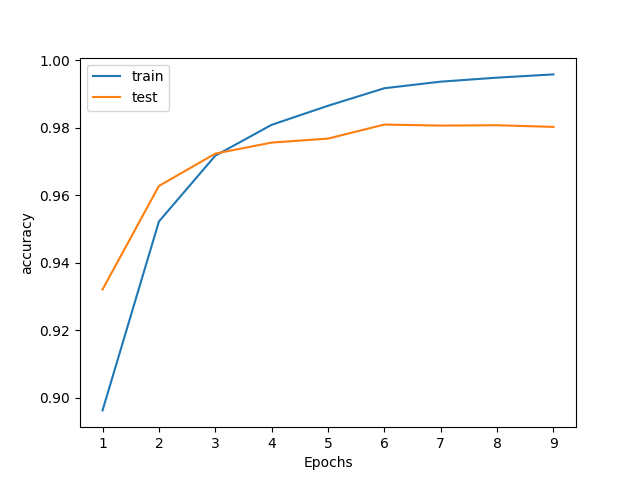

In [14]:
stat_key = 'accuracy'

figax = None
figax = util.plot_stat(all_train_stats, key=stat_key, figax=figax, label='train')
figax = util.plot_stat(all_test_stats, key=stat_key, figax=figax, label='test')
fig, ax = figax
plt.sca(ax)
plt.xlabel('Epochs')
plt.ylabel(stat_key)
plt.legend()